# Predicción de Series Temporales con Redes Neuronales

## Usaremos Keras y Tensorflow

Importamos las Librerías que vamos a utilizar

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

### Cargamos nuestro Dataset

Utilizamos aquí un ejemplo sencillo de datos, las ventas de un comercio

In [ ]:
df = pd.read_csv('time_series.csv',  parse_dates=[0], header=None,index_col=0, squeeze=True,names=['fecha','unidades'])
df.head()

In [ ]:
df.rename(columns={'periodo_orbital':'periodo orbital',
                        'método':'método descubrimiento'},
               inplace=True)

In [33]:
df.head()

fecha
2017-01-02    236
2017-01-03    237
2017-01-04    290
2017-01-05    221
2017-01-07    128
Name: unidades, dtype: int64

In [5]:
df.describe()

count    604.000000
mean     215.935430
std       75.050304
min       51.000000
25%      171.000000
50%      214.000000
75%      261.250000
max      591.000000
Name: unidades, dtype: float64

In [6]:
print(df.index.min())
print(df.index.max())

2017-01-02 00:00:00
2018-11-30 00:00:00


In [7]:
print(len(df['2017']))
print(len(df['2018']))

315
289


In [37]:
# potente con resample sacamos los valores de media por meses
meses =df.resample('M').mean()
meses

fecha
2017-01-31    203.923077
2017-02-28    184.666667
2017-03-31    182.964286
2017-04-30    198.960000
2017-05-31    201.185185
2017-06-30    209.518519
2017-07-31    278.923077
2017-08-31    316.000000
2017-09-30    222.925926
2017-10-31    207.851852
2017-11-30    185.925926
2017-12-31    213.200000
2018-01-31    201.384615
2018-02-28    190.625000
2018-03-31    174.846154
2018-04-30    186.000000
2018-05-31    190.666667
2018-06-30    196.037037
2018-07-31    289.500000
2018-08-31    309.038462
2018-09-30    230.518519
2018-10-31    209.444444
2018-11-30    184.481481
Freq: M, Name: unidades, dtype: float64

In [38]:
df.index

DatetimeIndex(['2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
               '2017-01-07', '2017-01-09', '2017-01-10', '2017-01-11',
               '2017-01-12', '2017-01-13',
               ...
               '2018-11-21', '2018-11-22', '2018-11-23', '2018-11-24',
               '2018-11-25', '2018-11-26', '2018-11-27', '2018-11-28',
               '2018-11-29', '2018-11-30'],
              dtype='datetime64[ns]', name='fecha', length=604, freq=None)

In [45]:
# meses.shape

meses ['2017']

#meses ['2018']

fecha
2017-01-31    203.923077
2017-02-28    184.666667
2017-03-31    182.964286
2017-04-30    198.960000
2017-05-31    201.185185
2017-06-30    209.518519
2017-07-31    278.923077
2017-08-31    316.000000
2017-09-30    222.925926
2017-10-31    207.851852
2017-11-30    185.925926
2017-12-31    213.200000
Freq: M, Name: unidades, dtype: float64

Diferencia de **series temporales con Regresión** son basicamente dos cosas:

Es dependiente del Tiempo. Esto rompe con el requerimiento que tiene la regresión lineal de que sus observaciones sean independientes.

Suelen tener algún tipo de estacionalidad, tendencias 

## Visualizaciones

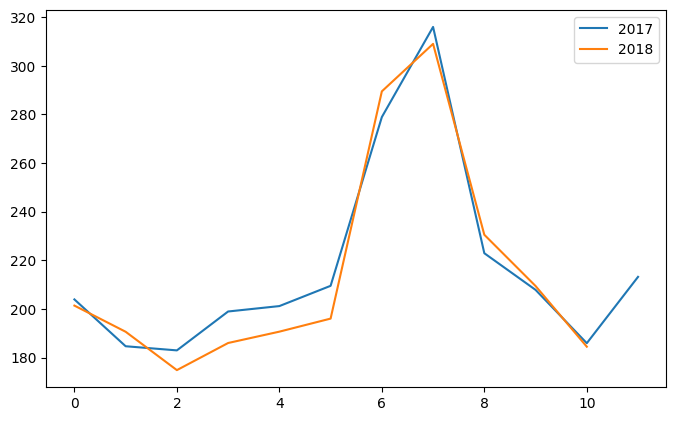

In [68]:
plt.figure(figsize=(8,5), dpi=100)

v2017=meses['2017'].values
plt.plot(v2017, label='2017')

v2018=meses['2018'].values
plt.plot(v2018, label='2018')

plt.legend()
plt.show()
#plt.plot(meses['2018'].values)

En 2017 se puede comprobar que hay un inicio de año con un descenso en la cantidad de unidades, luego comienza a subir hasta el verano con los meses entre junio y parte de agosto con la mayor cantidad de ventas. Finalmente vuelve a disminuir y tiene un pequeño pico al final del año (posiblemente por la campaña navideña)

También vemos que 2018 (naranja) se comporta prácticamente igual. Es decir que pareciera que tenemos una estacionalidad. Por ejemplo podríamos aventurarnos a pronosticar que “el verano de 2019 también tendrá un pico de ventas”.

In [46]:
verano2017 = df['2017-06-01':'2017-09-01']
verano2017

fecha
2017-06-01    218
2017-06-02    158
2017-06-03    125
2017-06-05    248
2017-06-06    221
             ... 
2017-08-28    369
2017-08-29    299
2017-08-30    298
2017-08-31    265
2017-09-01    311
Name: unidades, Length: 80, dtype: int64

In [47]:
verano2017.shape

(80,)

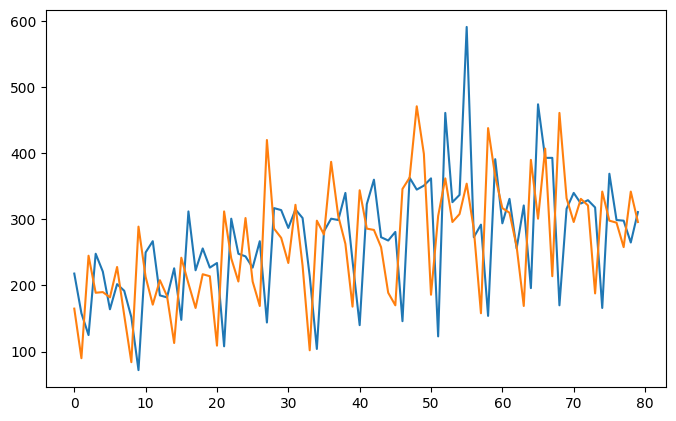

In [71]:
plt.figure(figsize=(8,5), dpi=100)

verano2017 = df['2017-06-01':'2017-09-01']
plt.plot(verano2017.values)
verano2018 = df['2018-06-01':'2018-09-01']
plt.plot(verano2018.values)

# Preprocesado de los datos

In [48]:
PASOS=7

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,-0.314815,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333
8,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407
9,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222
10,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444
11,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444,-0.344444


Usaremos como entradas las columnas encabezadas como var1(t-7) a (t-1) y nuestra salida (lo que sería el valor “Y” de la función) será el var1(t) **-la última columna-**

## Dividimos en set de Entrenamiento y Validación

In [49]:
# split into train and test sets
values = reframed.values
n_train_days = 315+289 - (30+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(567, 1, 7) (567,) (30, 1, 7) (30,)


# Creamos el Modelo de Red Neuronal

## Utilizaremos una Red "normal" Feedforward

más que normal, sencilla

In [50]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model


## Entrenamos nuestra máquina - nuesto modelo en redes neuronales para predicción en series temporales, última columna

In [82]:
EPOCHS=40

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1, 7)              56        
_________________________________________________________________
flatten_2 (Flatten)          (None, 7)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 8         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
81/81 [==============================] - 1s 6ms/step - loss: 0.3533 - mse: 0.1793 - val_loss: 0.2104 - val_mse: 0.0809
Epoch 2/40
81/81 [==============================] - 0s 2ms/step - loss: 0.2479 - mse: 0.1010 - val_loss: 0.1940 - val_mse: 0.0665
Epoch 3/40
81/81 [==============================] - 0s 1ms/step - loss: 0.2254 - mse: 0.0863 - val_loss: 0.1777 - val_mse: 0.058

## Visualizamos Resultados

30


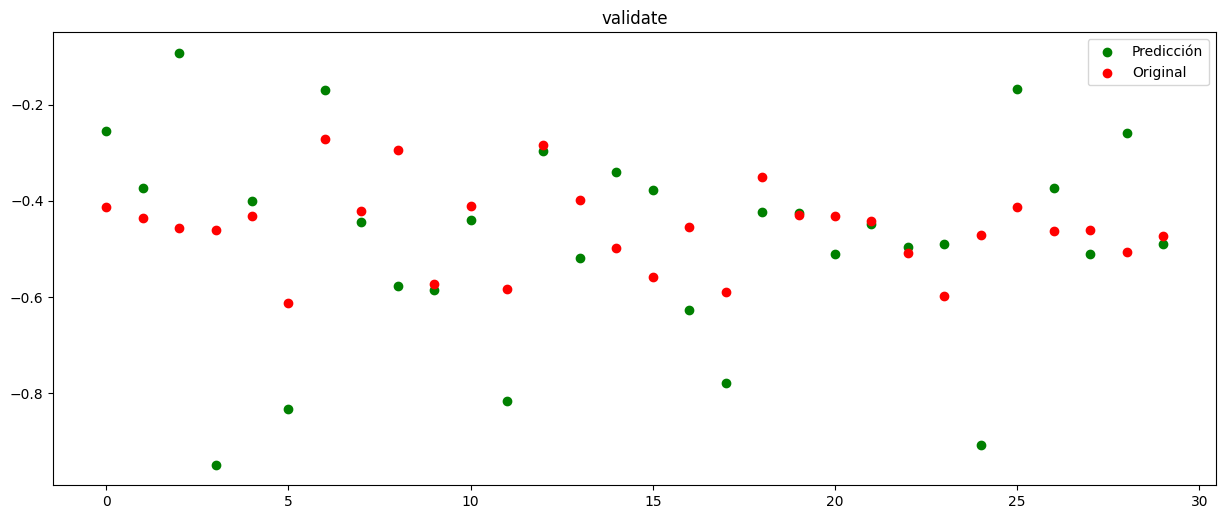

In [81]:
plt.figure(figsize=(15,6), dpi=100)

results=model.predict(x_val)
print( len(results) )
plt.scatter(range(len(y_val)),y_val,c='g', label='Predicción')
plt.scatter(range(len(results)),results,c='r', label='Original')
plt.legend()
plt.title('validate')
plt.show()


Podemos ver en la gráfica que los puntos verdes intentan **aproximarse** a los rojos. 

Cuanto más cerca o justamente superpuestos mejor. 
Normalmente aumentando la cantidad de EPOCHS se mejora, pero ojo ocn el sobreentrenamiento, **overfitting**


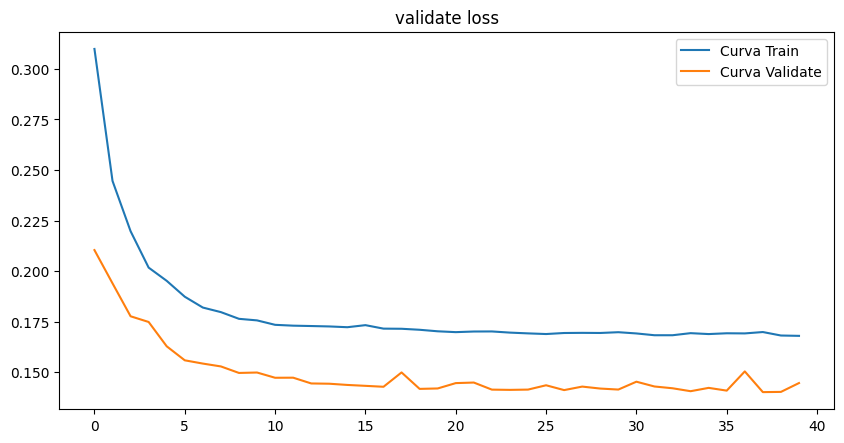

In [84]:
plt.figure(figsize=(10,5), dpi=100)

plt.plot(history.history['loss'], label='Curva Train')
plt.title('loss')
plt.plot(history.history['val_loss'], label='Curva Validate')
plt.legend()
plt.title('validate loss')
plt.show()

Disminuye el LOSS según se ha visto en el conjunto de entrenamiento y validación del modelo. Esto indica que el modelo está aprendiendo. 

Además, parece que no hay **overfitting** ya que las curvas de train y validate son distintas.

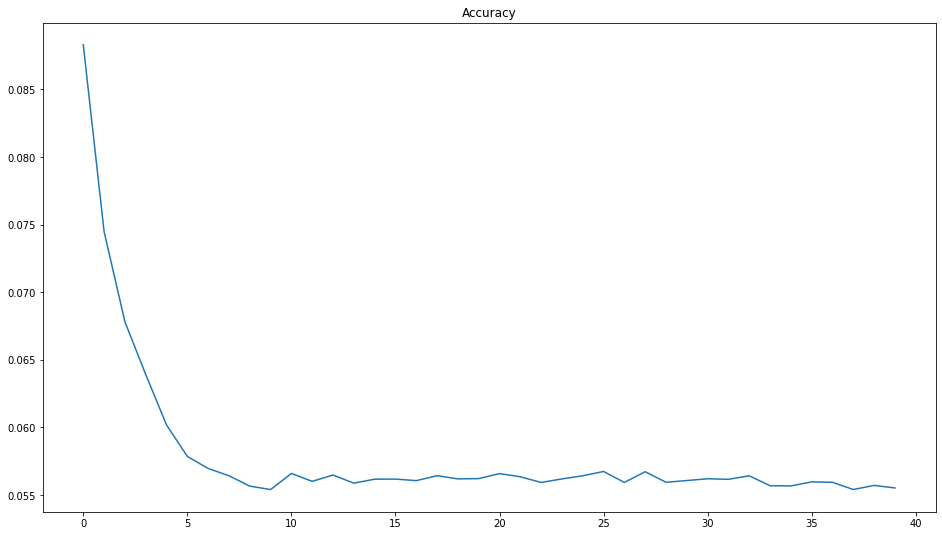

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['mse'])
plt.show()

In [86]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head()

,real,prediccion,diferencia
0,252.000000,209.357346,42.642654
1,220.000000,203.378006,16.621994
2,296.000000,197.840073,98.159927
3,64.999992,196.664246,-131.664246
4,213.000000,204.291687,8.708313


In [87]:
compara2.describe()

,real,prediccion,diferencia
count,30.000000,30.000000,30.000000
mean,191.633331,197.791946,-6.158576
std,57.580811,23.758911,51.700226
min,64.999992,155.437729,-131.664246
25%,169.000000,184.874664,-29.819061
50%,200.500000,198.065964,-3.272339
75%,220.000000,208.783756,26.335655
max,296.000000,247.869431,98.159927


In [88]:
compara2.head()

,real,prediccion,diferencia
0,252.000000,209.357346,42.642654
1,220.000000,203.378006,16.621994
2,296.000000,197.840073,98.159927
3,64.999992,196.664246,-131.664246
4,213.000000,204.291687,8.708313


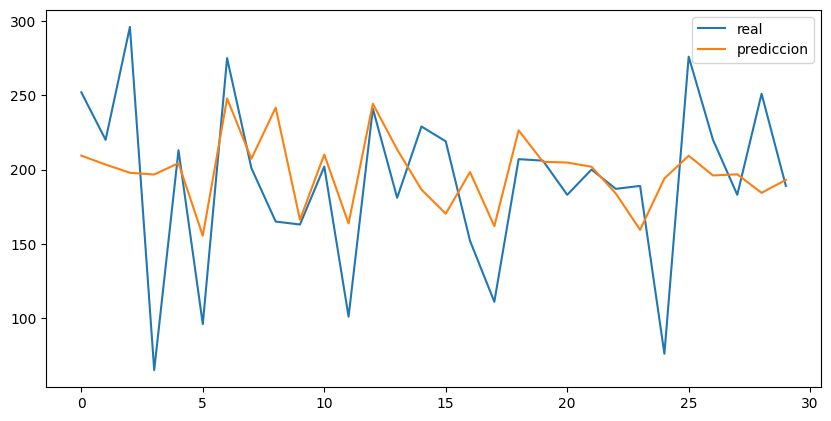

In [91]:
plt.figure(figsize=(10,5), dpi=100)

plt.plot(compara2['real'], label='real')
#plt.title('loss')

plt.plot(compara2['prediccion'], label='prediccion')

plt.legend()
#plt.title('validate loss')
plt.show()


In [ ]:
compara2['real'].plot()
compara2['prediccion'].plot()
#prediccion1SemanaDiciembre.plot()

# Predicción

A partir de la última semana de noviembre 2018, intentaremos predecir la primer semana de diciembre.

La idea es que ahora que tenemos nuestra red, vamos a realizar una nueva predicción:

usaremos los últimos días de noviembre 2018 para calcular la primer semana de diciembre.

In [94]:
df

fecha
2017-01-02    236
2017-01-03    237
2017-01-04    290
2017-01-05    221
2017-01-07    128
             ... 
2018-11-26    276
2018-11-27    220
2018-11-28    183
2018-11-29    251
2018-11-30    189
Name: unidades, Length: 604, dtype: int64

In [95]:
ultimosDias = df['2018-11-16':'2018-11-30']
ultimosDias


fecha
2018-11-16    152
2018-11-17    111
2018-11-19    207
2018-11-20    206
2018-11-21    183
2018-11-22    200
2018-11-23    187
2018-11-24    189
2018-11-25     76
2018-11-26    276
2018-11-27    220
2018-11-28    183
2018-11-29    251
2018-11-30    189
Name: unidades, dtype: int64

## Preparamos los datos para Test

In [99]:
values = ultimosDias.values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[7]], axis=1, inplace=True)  # es la salida, o sea la que queremos predecir
reframed.head(7)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,-0.24,-0.65,0.31,0.30,0.07,0.24,0.11
8,-0.65,0.31,0.30,0.07,0.24,0.11,0.13
9,0.31,0.30,0.07,0.24,0.11,0.13,-1.00
10,0.30,0.07,0.24,0.11,0.13,-1.00,1.00
11,0.07,0.24,0.11,0.13,-1.00,1.00,0.44
12,0.24,0.11,0.13,-1.00,1.00,0.44,0.07
13,0.11,0.13,-1.00,1.00,0.44,0.07,0.75


De este conjunto “ultimosDias” tomamos sólo la última fila, que es la que corresponde con la última semana de noviembre 

Luego tenemos que ajustar para el formato correcto para la red neuronal con reshape

In [100]:
values = reframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
x_test

(1, 1, 7)


array([[[ 0.11000001,  0.13      , -1.        ,  1.        ,
          0.44000006,  0.06999993,  0.75      ]]], dtype=float32)

In [101]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

## Pronóstico para la "próxima semana"

In [102]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])
    

[[[ 0.11000001  0.13       -1.          1.          0.44000006
    0.06999993  0.75      ]]]
[[[ 0.13       -1.          1.          0.44000006  0.06999993
    0.75       -0.00550025]]]
[[[-1.          1.          0.44000006  0.06999993  0.75
   -0.00550025 -0.15772107]]]
[[[ 1.          0.44000006  0.06999993  0.75       -0.00550025
   -0.15772107  0.44709054]]]
[[[ 0.44000006  0.06999993  0.75       -0.00550025 -0.15772107
    0.44709054  0.22461665]]]
[[[ 0.06999993  0.75       -0.00550025 -0.15772107  0.44709054
    0.22461665  0.21457863]]]
[[[ 0.75       -0.00550025 -0.15772107  0.44709054  0.22461665
    0.21457863  0.40933457]]]


## Re-Convertimos los resultados

In [103]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([-0.00550025], dtype=float32), array([-0.15772107], dtype=float32), array([0.44709054], dtype=float32), array([0.22461665], dtype=float32), array([0.21457863], dtype=float32), array([0.40933457], dtype=float32), array([0.03011942], dtype=float32)]


array([[175.44997773],
       [160.22789538],
       [220.70905762],
       [198.46166816],
       [197.45786631],
       [216.93346091],
       [179.01194496]])

## Visualizamos el pronóstico

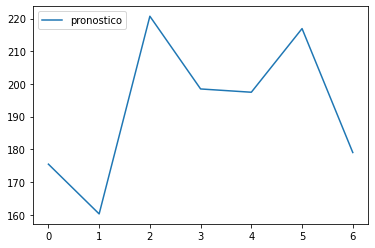

In [104]:
prediccion1SemanaDiciembre = pd.DataFrame(inverted)
prediccion1SemanaDiciembre.columns = ['pronostico']
prediccion1SemanaDiciembre.plot()
prediccion1SemanaDiciembre.to_csv('pronostico.csv') # guardamos el nuevo fichero con los datos generados

In [ ]:
prediccion1SemanaDiciembre

,pronostico
0,174.489041
1,141.269341
2,225.492924
3,203.732623
4,177.309417
5,208.155225
6,175.236986


# Agregamos el resultado en el dataset

In [ ]:
i=0
for fila in prediccion1SemanaDiciembre.pronostico:
    i=i+1
    ultimosDias.loc['2018-12-0' + str(i) + ' 00:00:00'] = fila
    print(fila)
ultimosDias.tail(14)

174.48904094075502
141.26934128856678
225.49292353152313
203.73262324331603
177.30941712430308
208.15522539962586
175.23698644310952


fecha
2018-11-24 00:00:00    189.000000
2018-11-25 00:00:00     76.000000
2018-11-26 00:00:00    276.000000
2018-11-27 00:00:00    220.000000
2018-11-28 00:00:00    183.000000
2018-11-29 00:00:00    251.000000
2018-11-30 00:00:00    189.000000
2018-12-01 00:00:00    174.489041
2018-12-02 00:00:00    141.269341
2018-12-03 00:00:00    225.492924
2018-12-04 00:00:00    203.732623
2018-12-05 00:00:00    177.309417
2018-12-06 00:00:00    208.155225
2018-12-07 00:00:00    175.236986
Name: unidades, dtype: float64